In [ ]:
Pkg.add("LibExpat"); using LibExpat
Pkg.add("Winston"); using Winston

Pkg.clone("MXNet");
ENV["MXNET_HOME"] = "/mxnet"
Pkg.add("GraphPlot");
Pkg.add("NetworkViz");
Pkg.add("PyPlot");
Pkg.add("MLBase")

In [ ]:
Pkg.add("GraphPlot");

In [6]:
using MXNet
using GraphPlot

In [7]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs


Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


In [8]:
osm_fn = "northern_stockholm.osm"

"northern_stockholm.osm"

In [9]:
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph(osm_fn);

getOSMData
 23.122502 seconds (251.67 M allocations: 10.940 GiB, 35.73% gc time)
intersections
  0.005464 seconds (24.55 k allocations: 2.920 MiB)
roadways
  0.011456 seconds (5.36 k allocations: 575.423 KiB)
segmentHighways
  0.256788 seconds (289.22 k allocations: 9.448 MiB, 4.45% gc time)
createGraph
  0.354863 seconds (1.91 M allocations: 74.455 MiB, 14.68% gc time)
 25.179167 seconds (254.69 M allocations: 11.067 GiB, 33.13% gc time)


In [10]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x -> vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon)
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = nodesLLA[k].coords.lat
end

59.4048694,17.9409198
59.3479227,18.0300213
59.3978055,17.8827928
59.4223701,17.8572134
59.3923518,18.0460295
59.3470279,17.8938963
59.3559978,17.9481098
59.3587283,17.9966055
59.3786329,18.0128975
59.4347686,18.001137
59.3991921,17.9823037
59.3498679,18.0451873
59.3864215,17.9390323
59.3475125,18.004639
59.3518059,17.9566719
59.4085271,18.019
59.4014547,17.9712111
59.3581566,17.9751434
59.3533616,17.9198966
59.3889355,17.8255881
59.3612971,17.9653226
59.3758198,17.9707441
59.4066667,17.8419661
59.4251456,17.8238364
59.4400075,18.0430397
59.3327128,17.9801786
59.3365941,17.9908026
59.4193234,17.9137125
59.392082,17.8700651
59.3512107,18.0437213
59.3501952,18.0382405
59.3814577,17.978106
59.396298,17.9511611
59.4028937,17.9435934
59.4341759,18.0016381
59.3715755,18.017518
59.4372311,17.9907863
59.4373389,17.9257411
59.3415023,17.9614384
59.3347063,17.9684336
59.4098845,18.0325786
59.3394885,18.0366458
59.3880785,17.8885217
59.4105799,17.768552
59.3617132,18.0001366
59.4144859,17.9299212

59.416161,17.8312618
59.4193217,17.9141942
59.3545778,18.0364799
59.3643979,18.0237616
59.3471562,18.0316461
59.3786921,18.0129971
59.3848493,18.0427713
59.3311587,18.0307809
59.423504,17.9478542
59.3308362,18.0099649
59.3444787,17.9657372
59.3490007,18.0413946
59.3999798,18.0157303
59.4097657,18.0338435
59.415481,17.8774987
59.3765225,17.972084
59.3530325,18.0388168
59.4315618,17.9215512
59.3841193,17.997966
59.401277,17.9668434
59.3987607,17.8843774
59.4112554,17.8962085
59.3739238,18.0010697
59.3285909,18.0214417
59.4059637,17.8330423
59.374267,17.9248157
59.3461305,18.0293323
59.3640836,18.0159291
59.3485342,17.97127
59.4078911,17.844055
59.3959262,17.9405351
59.3987209,18.0395908
59.3283403,18.0220561
59.4112346,17.8963604
59.3472617,18.0277577
59.4267067,17.9541213
59.3699476,17.9733794
59.4048212,17.9429358
59.3918239,18.0432953
59.3344376,18.0325712
59.3547809,17.9808222
59.4223951,17.8559186
59.362104,17.8640698
59.4231356,17.8042241
59.3414153,17.9841427
59.3532884,17.9809358

59.4412736,17.950063
59.3878244,17.866677
59.3302346,18.0210123
59.358401,17.9985231
59.4253556,17.8239707
59.4102494,17.9698918
59.3469021,17.9278425
59.4259891,17.8507082
59.3987978,17.9007782
59.3873992,18.0037669
59.3328365,18.0290942
59.3347817,17.9075924
59.3991363,17.8940313
59.34572,18.0339544
59.3859913,17.891962
59.3812098,17.9450151
59.3908171,17.8867394
59.3328389,17.9865444
59.393929,17.9871886
59.350454,18.0246592
59.3288006,17.9383936
59.3689441,18.0067233
59.4001223,17.8882735
59.3414953,17.9613089
59.4357533,17.9403737
59.4116646,18.0284789
59.4406674,17.9316979
59.348907,18.0415896
59.372404,18.0081949
59.38834,17.8033164
59.3462142,18.0270494
59.41587,17.9328961
59.4016445,17.9564242
59.3446493,17.9304313
59.3297512,17.9560679
59.3654548,17.9929496
59.3837803,18.0423735
59.3409765,17.8465634
59.3474916,18.03055
59.3590978,17.8724584
59.4149181,17.8279027
59.3787257,17.9541289
59.4151748,17.8282978
59.4180667,17.9368926
59.4344275,17.9499308
59.4167965,18.0029868
59.3

59.3346483,17.9509007
59.3424309,17.9237981
59.4407419,17.9313099
59.3298178,17.9173221
59.4208523,17.7947162
59.4246271,17.8334255
59.3737139,18.0177798
59.4304818,17.951257
59.3792716,17.9907546
59.4110743,17.8531369
59.3452192,18.0343805
59.3806374,17.8030089
59.3871868,17.9573296
59.4000873,17.8864673
59.3282358,18.017711
59.3748113,17.9277866
59.4313643,17.9415666
59.4028421,17.975136
59.3658439,17.8594962
59.3333269,17.9803162
59.34702,17.9287323
59.4246275,17.9469497
59.3395539,18.0366933
59.4048543,17.8489649
59.349944,18.0448723
59.3602755,17.8766642
59.3615735,17.943188
59.3464302,17.9639131
59.4212352,17.8449214
59.4096083,17.9629495
59.3923974,18.0403084
59.3831243,17.8655358
59.3463099,18.0268374
59.3810387,17.8943695
59.3492964,17.9857245
59.3887502,18.0425638
59.3725311,18.0038287
59.3494522,18.0059488
59.3422642,17.9250717
59.3824486,18.0414716
59.3344776,17.9680994
59.3368003,18.0100397
59.3746778,17.9266534
59.3421152,17.9505628
59.348144,18.0070632
59.4183925,17.9245

59.4179707,17.9286276
59.3672851,18.0073728
59.3915383,18.0411806
59.3887583,18.042728
59.399982,17.8901334
59.3795873,18.0147316
59.3587675,18.0290258
59.3989157,17.8859875
59.3293291,17.9828811
59.4117869,17.8557308
59.356248,17.9761744
59.4179843,18.0432847
59.3506164,18.0415069
59.3860301,17.8922836
59.3802006,18.0416344
59.3633476,18.0066296
59.3317178,17.9827826
59.353509,18.0390734
59.3465208,18.0089314
59.4346486,18.0023686
59.3448489,18.0073265
59.3871694,17.9395459
59.3952082,17.9864556
59.4028679,17.9743073
59.4022325,17.9523292
59.3412778,18.0377804
59.3417386,17.9256597
59.3966442,18.0355886
59.3657553,17.858925
59.3344111,17.9682993
59.340676,17.9756909
59.4376892,17.9347151
59.3835636,17.9835892
59.3749844,17.9273048
59.4178307,17.854672
59.3799513,17.9331464
59.4160405,17.8092535
59.3509258,18.004741
59.3248054,17.9572532
59.3319297,18.0237701
59.3518801,17.9564387
59.3794585,17.9660271
59.3799518,17.9324979
59.3818025,17.9382362
59.3367368,18.0344641
59.4295047,17.9517

59.4037762,17.9415063
59.3454088,17.9711932
59.3790919,17.9535883
59.3693894,17.9431348
59.3605718,17.9620364
59.3767098,18.0470107
59.3322763,18.0495833
59.3829895,17.990585
59.4148866,17.9396302
59.4303938,17.9497729
59.3470648,17.9582472
59.404082,17.9579282
59.3345155,18.0324488
59.3919528,17.8698797
59.4406177,17.9300314
59.4118126,17.9414453
59.3511728,17.8810782
59.3833051,18.0170276
59.3314664,17.8238128
59.3617146,17.8932771
59.3732697,17.9287971
59.4156033,17.8727263
59.4375522,17.9266929
59.3615832,17.9813331
59.3804202,18.0262428
59.4410241,17.9257099
59.3519471,17.9562856
59.3613402,17.9652868
59.4130531,18.0042489
59.3772517,18.0141447
59.3841153,17.965748
59.3447673,18.0394344
59.4348646,17.9972766
59.3408676,17.961694
59.4167455,17.9388756
59.3313557,18.0173605
59.3826354,17.7947027
59.3457294,18.0136896
59.4163092,17.9318184
59.3563096,18.0149386
59.3800746,18.0352856
59.333358,17.9883749
59.3997639,17.8841901
59.4095221,18.0353755
59.4249122,17.8473856
59.3689021,18.0

59.4288778,17.8282752
59.4032176,17.9526674
59.3601155,17.9748518
59.3973562,17.9099955
59.3816388,17.9386903
59.3299538,18.0040587
59.4344378,17.7846773
59.3791407,17.9536549
59.3529357,18.0404954
59.3821565,17.9793238
59.4209263,17.844723
59.3824847,18.0452402
59.3345269,17.9681893
59.3875898,17.9294882
59.376829,18.0041883
59.3490556,18.0126785
59.3811875,17.8970193
59.3773272,17.972637
59.3657919,17.8598489
59.3976067,18.0429153
59.3957014,17.9156192
59.3589301,17.8728028
59.3913167,18.0442561
59.3802669,17.9770974
59.3344575,18.0324191
59.4016496,17.877074
59.341926,18.0246431
59.3698108,17.942744
59.3893514,17.9394478
59.3285454,17.8088749
59.3988957,18.0340998
59.33505,18.0114882
59.4200356,17.922102
59.3449559,18.0187907
59.4162302,17.8764658
59.4140744,18.0399178
59.4355309,18.000977
59.3993591,17.9504446
59.3785042,18.012094
59.3471203,17.9621657
59.3789135,18.0097887
59.4182421,17.8558341
59.3483906,18.0096256
59.4142116,17.8297307
59.3736714,17.9277393
59.3627818,17.9924532

In [11]:
println(maximum(locs_x))
println(minimum(locs_x))
println(maximum(locs_y))
println(minimum(locs_y))

18.0560899
17.757927
59.4499366
59.3243546


In [12]:
edge_weights = Dict()

for (edge, info_dict) in edgeDict
    edgeDict[edge][:bad_weather] = false
    num_vehicles = Int(ceil(randexp()) * 10)
    info_dict[:num_vehicles] = num_vehicles
    edge_weight = generate_weights_with_factors(info_dict[:segmentlen], 
                                                info_dict[:speed],
                                                num_vehicles=num_vehicles)
    
    info_dict[:weight] = edge_weight
    edge_weights[(edge.src, edge.dst)] = edge_weight
end

max_edge_weight = maximum(values(edge_weights))
min_edge_weight = minimum(values(edge_weights))
println(max_edge_weight)
println(min_edge_weight)

271.1798618238079
0.08174731879352932


In [13]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    # normalize weights
    g_distmx[edge.src, edge.dst] = (info_dict[:weight] - min_edge_weight) / (max_edge_weight - min_edge_weight)
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y)

3488-element Array{Float64,1}:
 0.641133 
 0.187671 
 0.584884 
 0.78049  
 0.541457 
 0.180546 
 0.251972 
 0.273715 
 0.432214 
 0.879218 
 0.595925 
 0.20316  
 0.494234 
 ⋮        
 0.27245  
 0.995459 
 0.549779 
 0.709398 
 0.242751 
 0.200766 
 0.438345 
 0.224824 
 0.312873 
 0.684037 
 0.0513306
 0.203606 

# Below is a very neat plot of northern Stockholm road network

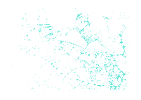

In [14]:
gplot(graph, locs_x, -locs_y, arrowlengthfrac=0.0)

In [20]:
calc_cosine_dist(p1, p2) = dot(p1, p2) / (norm(p1) * norm(p2))

calc_euclidean_dist(p1, p2) = norm(p1 - p2)

function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 7))
    
    x_u = norm_locs_x[node]
    y_u = norm_locs_y[node]
    x_dst = norm_locs_x[dst]
    y_dst = norm_locs_y[dst]

    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        x_v = norm_locs_x[out_neighbor]
        y_v = norm_locs_y[out_neighbor]
        
        ret[idx, 1] = 0.0
        ret[idx, 2] = g_distmx[node, out_neighbor]
        ret[idx, 3] = calc_cosine_dist([x_v-x_u, y_v-y_u], [x_dst-x_u, y_dst-y_u])
        ret[idx, 4] = calc_euclidean_dist([x_v, y_v], [x_dst, y_dst])
        ret[idx, 5] = x_v
        ret[idx, 6] = y_v
        
        ret[idx, end] = out_neighbor
        
    end
    
    return (ret, x_dst, y_dst)
    
end

encode_edges (generic function with 1 method)

In [ ]:
function generate_stochastic_dataset(G; sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        (src, dst) in keys(edge_weights) && continue    
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

In [ ]:
@time begin
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph, sample_size_lower_bound=10000, verbose_frequent=2000);
end
@assert length(features) == length(labels) == sample_cnt

In [ ]:
pair_path_dict

In [ ]:
max_path_len = maximum(map(e -> length(e), values(pair_path_dict)))
println(max_path_len)

# Is data augmentation really helpful?
Perhap when overdone, data augmentation only makes it harder to train.
As of this moment, data augmentation will be ignored.

In [ ]:
function find_label_idx(feature, label)
    
    num_row = size(feature)[1]
    ret_idx = 1
    
    for row_idx in 1:num_row
        if feature[row_idx, end] == label
            ret_idx = row_idx
        end
    end
    
    ret_idx
end

function augment_dataset(X, y; aug_multiple=20, verbose_frequent=500)
    
    org_sample_size = length(y)
    aug_sample_size = aug_multiple * org_sample_size
    feature_size = max_out_degree * 6 + 2
    
    X_aug, y_aug = zeros(Float32, aug_sample_size, feature_size), zeros(Int, aug_sample_size)
    indices = 1:max_out_degree
    
    cur_sample_idx = 1
    
    for pair in zip(X, y)
        feature = pair[1]
        label = pair[2]
        
        for _ in 1:aug_multiple
             
#             shuffled_indices = shuffle(MersenneTwister(now().instant.periods.value), indices)
            shuffled_indices = indices
            feature_tmp = feature[1][shuffled_indices, :]
            label_tmp = find_label_idx(feature_tmp, label)
            
            feature_tmp = transpose(feature_tmp[:, 1:end-1])

            
            X_aug[cur_sample_idx, :] = push!(vcat(feature_tmp...), feature[2], feature[3])
            y_aug[cur_sample_idx] = label_tmp - 1
            
            cur_sample_idx += 1
            
            if cur_sample_idx % verbose_frequent == 0
                println("Processed $(cur_sample_idx) samples")
            end
        end
    end
    
    return transpose(X_aug), y_aug
end

In [ ]:
X, y = augment_dataset(features, labels, aug_multiple=1, verbose_frequent=5000)

println(size(X))
println(size(y))

In [ ]:
count(x -> x == 0, y)

In [ ]:
split_at = [rand() > 0.2 for i in 1:length(y)]

X_train = X[:, split_at]
y_train = y[split_at]

X_val = X[:, .!split_at]
y_val = y[.!split_at];

In [ ]:
println(size(X_train))
println(size(y_train))
println(size(X_val))
println(size(y_val))

In [ ]:
function build_model(context)

    mlp = @mx.chain mx.Variable(:data)             =>
      mx.FullyConnected(name=:fc1, num_hidden=1024) =>
      mx.Activation(name=:relu1, act_type=:relu)   =>
      mx.FullyConnected(name=:fc2, num_hidden=512)  =>
      mx.Activation(name=:relu2, act_type=:relu)   =>
      mx.FullyConnected(name=:fc3, num_hidden=max_out_degree)  =>
      mx.SoftmaxOutput(name=:softmax)
    
    return mx.FeedForward(mlp, context=context)
end

# First overfit the entire dataset

In [ ]:
batch_size = 128

train_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size, shuffle=true)
val_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size);

In [ ]:
model = build_model(mx.gpu())

In [ ]:
mx.fit(model, mx.ADAM(),
    train_provider,
    n_epoch=150,
    eval_data=val_provider,
    verbosity=3)

In [ ]:
using MLBase

pred = mx.predict(model, 
        mx.ArrayDataProvider(X, batch_size=batch_size), verbosity=0)

pred = map(i -> indmax(pred[:, i]), 1:length(y))

confusmat(max_out_degree, y+1, pred)

In [ ]:
function nn_infer_next_node(G, parent, cur_node, src, dst, model)

    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    real_input_vec = push!(vcat(transpose(input_vec[:, 1:end-1])...), x_dst, y_dst)
    
    pred = mx.predict(model, mx.ArrayDataProvider(reshape(real_input_vec, :, 1)), verbosity=0)
    pred_idx = findmax(pred)[2]
    neighbor = Int(input_vec[pred_idx, end])
    
    if neighbor == 0
        
        avaliable_neighbors = filter(x -> x > 0, input_vec[:, end])
        
        if length(avaliable_neighbors) != 0
            println("Invalid prediction, randomizing next node")
            neighbor = Int(avaliable_neighbors[rand(1:end)])
        else
            # TODO the algorithm can be made smarter
            return -1, 0
        end
    end
    
    return neighbor, edge_weights[(cur_node, neighbor)]
end

function dijkstra_path_finder(G, src, dst, model; invalid_path_len_threshold=200)
    
    path = [src]
    parent_node = 0
    cur_node = src
    total_weights = 0.0
    
    while true
        if length(path) >= invalid_path_len_threshold
            return path, total_weights, false
        end
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        
        if next_node == -1
            
            if !has_edge(G, (cur_node, parent_node))
                return path, total_weights, false
            end
            
            println("No available node to choose, turning back")
            parent_node, cur_node = cur_node, parent_node
            continue
        end
        
        total_weights += weight
        push!(path, next_node)
        
        if next_node == dst
            return path, total_weights, true
        end
        
        parent_node = cur_node
        cur_node = next_node
    end

end

function build_ground_truth_path(src, dst)
    
    edges = pair_path_dict[(src, dst)]
    
    path = [edges[1].src]
    
    for edge in edges
       push!(path, edge.dst) 
    end
    
    path
end

In [ ]:
function calc_statistics(G, num_to_test)
   
    found_cnt = 0
    opt_path_cnt = 0
    
    pairs = shuffle(collect(keys(pair_path_dict)))[1:num_to_test]
    
    for pair in pairs
        src, dst = pair[1], pair[2]

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model, 
                                invalid_path_len_threshold=max_path_len * 2)
        dijkstra_path = build_ground_truth_path(src, dst)
        
        found == false && continue
        
        found_cnt += 1
        
        if nn_path == dijkstra_path
            opt_path_cnt += 1
        else
            println(nn_path)
            println(dijkstra_path)
        end
    end
    
    return found_cnt, opt_path_cnt
end

In [ ]:
function print_paths_statistics(G, num_to_test)

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, num_to_test)
    
    @printf "%d out of %d can find path: %f\n" found_cnt num_total_path float(found_cnt)/num_total_path
    @printf "%d out of %d can find optimal path: %f\n" opt_path_cnt found_cnt float(opt_path_cnt)/found_cnt
    @printf "%d out of %d all paths can find optimal paths: %f\n" opt_path_cnt num_total_path float(opt_path_cnt)/num_total_path
    
end

In [ ]:
print_paths_statistics(graph, 10)

# N.B.

When the model is able to find the optimal path
with high probability, the model has learned well.

In [ ]:
percentage_found = []
percentage_opt_found = []
percentage_opt_all = []

for _ in 1:10
    num_total_path = 200
    
    found_cnt, opt_path_cnt = calc_statistics(graph, num_total_path)
    push!(percentage_found, found_cnt/num_total_path)
    push!(percentage_opt_found, opt_path_cnt/found_cnt)
    push!(percentage_opt_all, opt_path_cnt/num_total_path)
end

In [ ]:
using PyPlot

boxplot([percentage_found, percentage_opt_found, percentage_opt_all],
        labels=["found/all", "opt/found", "opt/all"]) # Basic

In [15]:
using PyPlot
using PyCall

@pyimport networkx as nx

distmx = fill(Inf, (nv(graph), nv(graph)))

function build_networkx_graph(julia_graph)
    
    
    
    G = nx.DiGraph()
    
    for (edge, _) in edgeDict
#         print(node, coord[0], coord[1])
        weight = (0.5 * rand() + 0.5) * 
                        calc_euclidean_dist([norm_locs_x[edge.src], norm_locs_y[edge.src]], 
                                            [norm_locs_x[edge.dst], norm_locs_y[edge.dst]])
        nx.add_path(G, [edge.src, edge.dst], weight=weight)
        distmx[edge.src, edge.dst] = weight
    end
    
    G
end

function build_ground_truth_path(path_edges)
    
    path = [path_edges[1].src]
    edges = []
    
    for edge in path_edges
        push!(path, edge.dst)
        push!(edges, (edge.src, edge.dst))
    end
    
    return path, edges
end

function plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)
    
    G = build_networkx_graph(graph)
    
    pos = Dict()

    for node in 1:nv(graph)
        pos[node] = (locs_x[node], locs_y[node])
    end

    node_color = ["c" for _ in 1:nv(graph)];
    node_size = [0.01 for _ in 1:nv(graph)];
    
    # Mark ground truth path
    node_color[gt_path_nodes[end]] = "g"
    node_color[gt_path_nodes[1]] = "k"

    node_size[gt_path_nodes[1]] = 20
    node_size[gt_path_nodes[end]] = 20

    for node in gt_path_nodes[2:end-1]
        node_color[node] = "r"
        node_size[node] = 1
    end

    # Mark nn path
    for node in nn_path_nodes[2:end-1]
        node_color[node] = "b"
        node_size[node] = 1
    end
    
    nx.draw_networkx(G, pos=pos, 
                    with_labels=false,
                    nodelist=1:nv(graph),
                    node_size=node_size, 
                    width=0.01,
                    arrows=false,
                    node_color=node_color)
end

plot_gt_nn_comparison (generic function with 1 method)

In [18]:
gt_path_nodes = [1417, 2228, 763, 3, 3475, 2886, 1173, 2173, 1271, 1274, 2121, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 13, 1502, 2216, 1101, 1640, 127, 1039, 3351, 2764, 1562, 1667, 2078, 665, 551, 2747, 2856, 2432, 2556, 3034, 1899, 561, 2583, 3176, 80, 2723, 2514, 1960, 1099, 838, 1771, 1249, 999, 1804, 2748, 2905, 3356, 1123, 1309]
nn_path_nodes = [1417, 2228, 2855, 763, 3, 3475, 2886, 1173, 2181, 2932, 2262, 2720, 1050, 252, 3078, 1033, 1279, 2226, 2964, 434, 3131, 850, 2898, 369, 739, 1492, 1780, 1996, 2653, 2910, 251, 2524, 483, 545, 2832, 2486, 596, 3415, 127, 1039, 3351, 2764, 1562, 1667, 2078, 665, 551, 2747, 2856, 2432, 2556, 3034, 1899, 561, 2583, 3176, 80, 2723, 2514, 1960, 1099, 838, 1771, 1249, 999, 1804, 2748, 2905, 3356, 1123, 1309];

plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)